In [153]:
import h5py
import math
import pickle
import random
import pandas as pd
import numpy as np
from j2v import mag, w2v, util
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import entropy
from itertools import combinations
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from scipy.stats import pearsonr, ttest_ind
from collections import defaultdict, Counter
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
mapping = mag.load_map_jid_discipline('journal_discipline_map.csv')

14113 journals in MAG's Journal.txt were matched to UCSD data, and 29 of them are interdisciplinary journals in UCSD catelog.


In [3]:
vid2name = mag.get_venue_dict(key='id')
vname2vid = {name: vid for vid, name in vid2name.items()}

processing /l/nx/data/haopeng/j2v/Journals.txt...
finished processing!

processing /l/nx/data/haopeng/j2v/Conferences.txt...
finished processing!



### J2v

In [4]:
model = w2v.load_j2v(mag.get_path('100feat_50minwords_10context_2016'))


model shape is: (20835, 100) 



In [5]:
vid2index = dict((vid, i) for i, vid in enumerate(model.index2word))
index2vid = {i: vid for vid, i in vid2index.items()}

### Citation matrix

In [6]:
# see `get_citation_vec_model.ipynb`

h5f = h5py.File(mag.get_path('venue_citation_matrix.h5'),'r')
in_out_matrix = h5f['matrix'][:]
h5f.close()

In [7]:
with open(mag.get_path('venue_citation_matrix_index.pickle'), 'rb') as file:
    col_index2vid, vid2col_index = pickle.load(file)

In [10]:
with open(mag.get_path('venue_citation_degrees.pickle'), 'rb') as file:
    vid_out_sum, vid_in_sum = pickle.load(file)

### Jaccard-Similarity matrix based on inter-citation matrix

In [14]:
out_matrix = in_out_matrix[:, :len(in_out_matrix)]

In [15]:
np.sum(out_matrix, axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [20]:
out_sum = np.array([vid_out_sum[col_index2vid[i]] for i in range(len(out_matrix))])

In [21]:
out_matrix = np.multiply(out_matrix, out_sum[:, np.newaxis])

In [22]:
out_matrix[0]

array([8., 0., 0., ..., 0., 0., 0.])

In [23]:
out_matrix.shape

(24020, 24020)

In [29]:
raw = np.add(out_matrix, out_matrix.T)

In [26]:
np.allclose(raw, raw.T)

True

In [38]:
a = np.repeat(out_sum[:, np.newaxis], len(raw), axis=1)

In [64]:
del b

In [42]:
denominator = np.add(a, a.T)
denominator = np.subtract(denominator, raw)

In [63]:
np.allclose(denominator, denominator.T)

True

In [62]:
np.sum(denominator == 0)

4888546

In [71]:
denominator[21, 24]

0.0

In [76]:
sum(out_matrix[21])

0.0

In [77]:
sum(out_matrix[24])

0.0

In [79]:
np.sum(out_sum == 0)

2211

In [80]:
jac = np.divide(raw, denominator, out=np.zeros_like(raw), where = denominator!=0)

In [81]:
jac.shape

(24020, 24020)

In [82]:
np.allclose(jac, jac.T)

True

In [83]:
np.sum(np.isnan(jac))

0

In [145]:
jac[:5, :5]

array([[0.01188707, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.16129032, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.018215  , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.0228505 ]])

In [146]:
h5f = h5py.File(mag.get_path('jac_simi_matrix.h5'), 'w')
h5f.create_dataset('jac', data=jac)
h5f.close()

In [41]:
h5f = h5py.File(mag.get_path('jac_simi_matrix.h5'),'r')
jac = h5f['jac'][:]
h5f.close()

### Comparison

In [84]:
num_pairs = 100000

# within-discipline
pairs = []
for name, group in mapping.groupby('disc_name'):
    p = util.sample_pairs(group['jid'].tolist(), num_pairs//10)
    pairs.extend(p)
pairs = random.sample(pairs, num_pairs)

# cross-discipline
groups = []
for name, group in mapping.groupby('disc_name'):
    groups.append(group['jid'].tolist())
accross_pairs = util.sample_cross_group_pairs(groups, num_pairs//10)
accross_pairs = random.sample(accross_pairs, num_pairs)

# within-subdiscipline
pairs_subd = []
for name, subd_group in mapping.groupby('subd_name'):
    p = list(combinations(subd_group['jid'].tolist(), 2))
    pairs_subd.extend(p)
pairs_subd = random.sample(pairs_subd, num_pairs)

# random pairs
random_p = util.sample_pairs(mapping['jid'].tolist(), num_pairs)

This group is small, can not generate # of pairs required, return all pairs!


In [85]:
len(pairs)

100000

In [86]:
len(accross_pairs)

100000

In [87]:
len(pairs_subd)

100000

In [88]:
len(random_p)

100000

Rand pairs

In [179]:
j2v_rand = []
cite_vec_rand = []
jac_vec_rand = []

for j1, j2 in random_p:
    try:
        j2v_rand.append(model.similarity(j1, j2))
        cite_vec_rand.append(cosine_similarity(in_out_matrix[vid2col_index[j1]].reshape(1, -1), in_out_matrix[vid2col_index[j2]].reshape(1, -1))[0][0])
        jac_vec_rand.append(cosine_similarity(jac[vid2col_index[j1]].reshape(1, -1), jac[vid2col_index[j2]].reshape(1, -1))[0][0])
    except:
        # j not in model.
        pass

In [90]:
len(j2v_rand)

82012

In [93]:
np.mean(j2v_rand)

0.06916449723952565

In [94]:
np.mean(cite_vec_rand)

0.023673916604539214

In [95]:
np.mean(jac_vec_rand)

0.008177106402502951

In [19]:
ttest_ind(j2v_rand, cite_vec_rand)

Ttest_indResult(statistic=67.58213858224157, pvalue=0.0)

In [100]:
ttest_ind(j2v_rand, jac_vec_rand)

Ttest_indResult(statistic=89.50911764111048, pvalue=0.0)

cross disc pairs

In [101]:
j2v_simi_scores_diff = []
cite_vec_simi_scores_diff = []
jac_vec_simi_scores_diff = []

for j1, j2 in accross_pairs:
    try:
        j2v_simi_scores_diff.append(model.similarity(j1, j2))
        cite_vec_simi_scores_diff.append(cosine_similarity(in_out_matrix[vid2col_index[j1]].reshape(1, -1), in_out_matrix[vid2col_index[j2]].reshape(1, -1))[0][0])
        jac_vec_simi_scores_diff.append(cosine_similarity(jac[vid2col_index[j1]].reshape(1, -1), jac[vid2col_index[j2]].reshape(1, -1))[0][0])
    except:
        # j not in model.
        pass

In [102]:
len(j2v_simi_scores_diff)

83723

In [103]:
np.mean(j2v_simi_scores_diff)

0.027697164183546185

In [104]:
np.mean(cite_vec_simi_scores_diff)

0.02914569472484637

In [105]:
np.mean(jac_vec_simi_scores_diff)

0.00916482800339349

In [106]:
def KL_dist(j2v_simi_scores, j2v_rand, bd, kernel='gaussian'):
    kde_rand = KernelDensity(kernel=kernel, bandwidth = bd).fit(np.array(j2v_rand)[:, np.newaxis])
    logpdf_rand = kde_rand.score_samples(xs[:, np.newaxis])

    kde = KernelDensity(kernel=kernel, bandwidth = bd).fit(np.array(j2v_simi_scores)[:, np.newaxis])
    logpdf = kde.score_samples(xs[:, np.newaxis])

    return entropy(pk=np.exp(logpdf), qk=np.exp(logpdf_rand))

In [187]:
bd = 0.05
xs = np.linspace(-1, 1, 100)

In [108]:
KL_dist(j2v_simi_scores_diff, j2v_rand, bd)

0.025652405668179824

In [109]:
KL_dist(cite_vec_simi_scores_diff, cite_vec_rand, bd, kernel='exponential')

0.0020438105006284246

In [110]:
KL_dist(jac_vec_simi_scores_diff, jac_vec_rand, bd, kernel='exponential')

0.0001627485069352245

Same disc

In [180]:
j2v_simi_scores = []
cite_vec_simi_scores = []
jac_vec_simi_scores = []

for j1, j2 in pairs:
    try:
        j2v_simi_scores.append(model.similarity(j1, j2))
        cite_vec_simi_scores.append(cosine_similarity(in_out_matrix[vid2col_index[j1]].reshape(1, -1), in_out_matrix[vid2col_index[j2]].reshape(1, -1))[0][0])
        jac_vec_simi_scores.append(cosine_similarity(jac[vid2col_index[j1]].reshape(1, -1), jac[vid2col_index[j2]].reshape(1, -1))[0][0])
    except:
        # j not in model.
        pass

In [113]:
len(j2v_simi_scores)

83541

In [114]:
np.mean(j2v_simi_scores)

0.24450503418052433

In [115]:
np.mean(cite_vec_simi_scores)

0.10001923978476264

In [116]:
np.mean(jac_vec_simi_scores)

0.04597340154847054

In [117]:
KL_dist(j2v_simi_scores, j2v_rand, bd)

0.3416988110338021

In [118]:
KL_dist(cite_vec_simi_scores, cite_vec_rand, bd, kernel='exponential')

0.252504538566558

In [119]:
KL_dist(jac_vec_simi_scores, jac_vec_rand, bd, kernel='exponential')

0.10722109896132394

Same sub disc

In [120]:
j2v_simi_scores_sub = []
cite_vec_simi_scores_sub = []
jac_vec_simi_scores_sub = []

for j1, j2 in pairs_subd:
    try:
        j2v_simi_scores_sub.append(model.similarity(j1, j2))
        cite_vec_simi_scores_sub.append(cosine_similarity(in_out_matrix[vid2col_index[j1]].reshape(1, -1), in_out_matrix[vid2col_index[j2]].reshape(1, -1))[0][0])
        jac_vec_simi_scores_sub.append(cosine_similarity(jac[vid2col_index[j1]].reshape(1, -1), jac[vid2col_index[j2]].reshape(1, -1))[0][0])
    except:
        # j not in model.
        pass

In [121]:
len(j2v_simi_scores_sub)

81796

In [122]:
np.mean(j2v_simi_scores_sub)

0.5403486794027654

In [123]:
np.mean(cite_vec_simi_scores_sub)

0.28430442394591154

In [124]:
np.mean(jac_vec_simi_scores_sub)

0.17498856619235828

In [125]:
KL_dist(j2v_simi_scores_sub, j2v_rand, bd)

2.061762562946193

In [126]:
KL_dist(cite_vec_simi_scores_sub, cite_vec_rand, bd, kernel='exponential')

1.5721923659100108

In [127]:
KL_dist(jac_vec_simi_scores_sub, jac_vec_rand, bd, kernel='exponential')

1.070938566177922

Plot

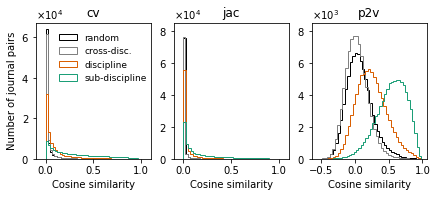

In [152]:
a = 1
b = 40
fig, (ax1, ax2, ax3)= plt.subplots(1, 3, figsize=(7, 2.5))

ax1.hist(cite_vec_rand, bins = b, alpha = a, label = 'random', color = 'black', histtype='step')
ax1.hist(cite_vec_simi_scores_diff, bins = b, alpha = a, label = 'cross-disc.',  color = '#808080', histtype='step')
ax1.hist(cite_vec_simi_scores, bins = b, alpha = a, label = 'discipline',  color = '#d95f02', histtype='step')
ax1.hist(cite_vec_simi_scores_sub, bins = b, alpha = a, label = 'sub-discipline',  color = '#1b9e77', histtype='step')
ax1.set_ylabel('Number of journal pairs')
ax1.set_xlabel('Cosine similarity')
ax1.set_xlim(-0.1, 1.1)
# ax1.set_yscale('log')
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
ax1.set_title('cv')

ax2.hist(jac_vec_rand, bins = b, alpha = a, label = 'random', color = 'black', histtype='step')
ax2.hist(jac_vec_simi_scores_diff, bins = b, alpha = a, label = 'cross-disc.',  color = '#808080', histtype='step')
ax2.hist(jac_vec_simi_scores, bins = b, alpha = a, label = 'discipline',  color = '#d95f02', histtype='step')
ax2.hist(jac_vec_simi_scores_sub, bins = b, alpha = a, label = 'sub-discipline',  color = '#1b9e77', histtype='step')
ax2.set_xlabel('Cosine similarity')
# ax2.set_ylabel('Number of journal pairs')
ax2.set_xlim(-0.1, 1.1)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
ax2.set_ylim([0, 8.5e4])
ax2.set_yticks([0, 2e4, 4e4, 6e4, 8e4])
ax2.set_title('jac')

ax3.hist(j2v_rand, bins = b, alpha = a, label = 'random', color = 'black', histtype='step')
ax3.hist(j2v_simi_scores_diff, bins = b, alpha = a, label = 'cross-disc.',  color = '#808080', histtype='step')
ax3.hist(j2v_simi_scores, bins = b, alpha = a, label = 'discipline',  color = '#d95f02', histtype='step')
ax3.hist(j2v_simi_scores_sub, bins = b, alpha = a, label = 'sub-discipline',  color = '#1b9e77', histtype='step')
ax3.set_xlabel('Cosine similarity')
# ax3.set_ylabel('Number of journal pairs')
ax3.set_title('p2v')
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
ax3.set_ylim([0, 8.5e3])
ax3.set_yticks([0, 2e3, 4e3, 6e3, 8e3])
ax3.set_xticks([-0.5, 0, 0.5, 1])

ax1.legend(loc='lower left', bbox_to_anchor=(0.13, 0.5), fontsize = 9, frameon = False)

fig.subplots_adjust(wspace=0.2, hspace=0)
plt.show()
fig.savefig('j2v_vs_cite_simi.pdf', bbox_inches='tight', pad_inches=0.01)